In [1]:
from collections import defaultdict
from json import dumps
import os, urllib.request
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datasets
import transformers
import torch
import tqdm

from projection_simplex_vectorized import projection_simplex
from postprocess import PostProcessorDP
import utils

model_name = "bert-base-uncased"
model_dir = "models/biasbios_squared_loss"

n_epochs = 3
batch_size = 32
lr = 2e-5
warmup_ratio = 0.1
weight_decay = 0.01
max_grad_norm = 1.0

split_ratio_for_postprocessing = 0.05

seed = 33
transformers.set_seed(seed)
rng = np.random.default_rng(seed)
bw = 1 / 1000
n_perturbations_train = 10
n_perturbations_eval = 1000

device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

## Download and load BiasBios dataset

In [2]:
label_names = [
    "accountant", "architect", "attorney", "chiropractor", "comedian",
    "composer", "dentist", "dietitian", "dj", "filmmaker", "interior_designer",
    "journalist", "model", "nurse", "painter", "paralegal", "pastor",
    "personal_trainer", "photographer", "physician", "poet", "professor",
    "psychologist", "rapper", "software_engineer", "surgeon", "teacher",
    "yoga_teacher"
]
n_classes = len(label_names)

group_names = ["female", "male"]
n_groups = len(group_names)

features = datasets.Features({
    "bio": datasets.Value("string"),
    "title": datasets.ClassLabel(names=label_names),
    "gender": datasets.ClassLabel(names=group_names),
})

train_path = "data/biasbios/train.pickle"
test_path = "data/biasbios/test.pickle"
dev_path = "data/biasbios/dev.pickle"
if any([not os.path.exists(p) for p in [train_path, test_path, dev_path]]):
  os.makedirs("data/biasbios", exist_ok=True)
  urllib.request.urlretrieve(
      "https://storage.googleapis.com/ai2i/nullspace/biasbios/train.pickle",
      train_path)
  urllib.request.urlretrieve(
      "https://storage.googleapis.com/ai2i/nullspace/biasbios/test.pickle",
      test_path)
  urllib.request.urlretrieve(
      "https://storage.googleapis.com/ai2i/nullspace/biasbios/dev.pickle",
      dev_path)

raw_dataset = {}
for split, path in zip(["train", "test", "dev"],
                       [train_path, test_path, dev_path]):
  rows = {k: [] for k in features}
  with open(path, "rb") as pickle_file:
    for row in pickle.load(pickle_file):
      rows["gender"].append("female" if row["g"] == "f" else "male")
      rows["title"].append(row["p"])
      rows["bio"].append(rows["gender"][-1] + ". " +
                         row["hard_text_untokenized"])
  raw_dataset[split] = datasets.Dataset.from_dict(rows, features=features)
raw_dataset = datasets.DatasetDict(raw_dataset)

print(dumps(raw_dataset["train"][0], indent=2))

{
  "bio": "female. She has been working with children in camp, community and school settings for the past 8 years. She believes in the importance of cultivating self-love and awareness in black children at a very young age and is excited to be apart of Black Lives Matter Toronto\u2019s Freedom School!",
  "title": 26,
  "gender": 0
}


In [3]:
# Compute and print dataset statistics

dataset = datasets.concatenate_datasets([d for d in raw_dataset.values()])
labels = np.array(label_names)[dataset["title"]]
groups = np.array(group_names)[dataset["gender"]]
df = pd.DataFrame(np.stack([groups, labels], axis=1),
                  columns=["Group", "Target"])
df_grouped = df.groupby(["Target", "Group"]).size().unstack()
counts = df_grouped.sum(axis=0)

n_groups = len(group_names)
n_classes = len(df_grouped.index)

print("Dataset statistics:")
display(df_grouped / counts)
display(pd.DataFrame(counts, columns=["Count"]).T)

print()
print("Perfect results if dataset equals population:")
display(
    pd.DataFrame({
        "group_balanced_err": {
            "no_postprocess":
                0.0,
            "postprocess":
                PostProcessorDP().fit(
                    np.concatenate([np.eye(n_classes) for _ in range(n_groups)],
                                   axis=0),
                    np.repeat(np.arange(n_groups), n_classes),
                    p=np.nan_to_num((df_grouped.to_numpy() /
                                     counts.to_numpy())).T.flatten()).score_
        },
        "dp_gap": {
            "no_postprocess": utils.dp_gap(labels, groups),
            "postprocess": 0.0
        }
    }))

Dataset statistics:


Group,female,male
Target,,
accountant,0.011428,0.016898
architect,0.013168,0.036508
attorney,0.068610,0.095177
chiropractor,0.003789,0.009029
comedian,0.003251,0.010444
composer,0.005041,0.022156
dentist,0.028297,0.044132
dietitian,0.020258,0.001368
dj,0.001159,0.006029


Group,female,male
Count,182102,211321



Perfect results if dataset equals population:


,group_balanced_err,dp_gap
no_postprocess,0.000000,0.231247
postprocess,0.115624,0.000000


### Tokenize BiasBios dataset

In [4]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
  tokenized_examples = tokenizer(examples["bio"],
                                 padding=False,
                                 max_length=tokenizer.model_max_length,
                                 truncation=True)
  tokenized_examples["labels"] = examples["title"]
  tokenized_examples["group_labels"] = examples["gender"]
  return tokenized_examples


tokenized_dataset = raw_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=raw_dataset["train"].column_names,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/256 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/99 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/40 [00:00<?, ?ba/s]

In [5]:
# Train data split
split_dataset = tokenized_dataset["train"].train_test_split(
    test_size=split_ratio_for_postprocessing, seed=seed)
train_dataset_predictor = split_dataset["train"]
train_dataset_postprocessor = split_dataset["test"]
test_dataset = tokenized_dataset["test"]
# dev_dataset = tokenized_dataset["dev"]

data_collator = transformers.DataCollatorWithPadding(tokenizer)
train_dataloader_predictor = torch.utils.data.DataLoader(
    train_dataset_predictor,
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size)
train_dataloader_postprocessor = torch.utils.data.DataLoader(
    train_dataset_postprocessor,
    collate_fn=data_collator,
    batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              collate_fn=data_collator,
                                              batch_size=batch_size)
# dev_dataloader = torch.utils.data.DataLoader(dev_dataset,
#                                              collate_fn=data_collator,
#                                              batch_size=batch_size)

## Load/train NLU model

In [6]:
model = None
is_finetuned = False
if os.path.exists(model_dir):
  model = transformers.AutoModelForSequenceClassification.from_pretrained(
      model_dir).to(device)
  is_finetuned = True
else:
  model = transformers.AutoModelForSequenceClassification.from_pretrained(
      model_name, num_labels=n_classes).to(device)

model_input_args = list(model.forward.__code__.co_varnames)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [7]:
if not is_finetuned:
  no_decay = ["bias", "LayerNorm.weight"]
  optimizer_grouped_parameters = [
      {
          "params": [
              p for n, p in model.named_parameters()
              if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": weight_decay,
      },
      {
          "params": [
              p for n, p in model.named_parameters()
              if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.0
      },
  ]
  optimizer = transformers.AdamW(optimizer_grouped_parameters, lr=lr)
  lr_scheduler = transformers.get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=(warmup_ratio * n_epochs *
                        len(train_dataloader_predictor)),
      num_training_steps=n_epochs * len(train_dataloader_predictor))

  loss_fn = torch.nn.MSELoss()
  metric = datasets.load_metric("accuracy")

  for epoch in range(n_epochs):
    model.train()
    for batch in tqdm.tqdm(train_dataloader_predictor,
                           desc=f"epoch {epoch}, train"):
      batch = {
          k: v.to(device) for k, v in batch.items() if k in model_input_args
      }
      outputs = model(**batch)
      labels_one_hot = torch.nn.functional.one_hot(batch["labels"], n_classes)
      loss = loss_fn(outputs.logits, labels_one_hot.float())
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()
    model.eval()

    for batch in tqdm.tqdm(test_dataloader, desc=f"epoch {epoch}, eval"):
      batch = {
          k: v.to(device) for k, v in batch.items() if k in model_input_args
      }
      with torch.no_grad():
        outputs = model(**batch)
        probas = outputs.logits
        predictions = torch.argmax(probas, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])
    print(f"epoch {epoch}: {dumps(metric.compute(), indent=2)}")

  model.save_pretrained(model_dir)

epoch 0, eval: 100%|████████████████████████| 3074/3074 [02:38<00:00, 19.36it/s]


epoch 0: {
  "accuracy": 0.8477080452289921
}


epoch 1, eval: 100%|████████████████████████| 3074/3074 [02:38<00:00, 19.35it/s]


epoch 1: {
  "accuracy": 0.8543480029284959
}


epoch 2, eval: 100%|████████████████████████| 3074/3074 [02:38<00:00, 19.37it/s]


epoch 2: {
  "accuracy": 0.8576425608069633
}


## Post-process

In [8]:
# Define some utility functions


def add_metrics_to_dict(dictionary, model_name, test_labels, test_preds,
                        test_groups, n_groups):
  dictionary["group_balanced_err"][model_name] = utils.error_rate(
      test_labels,
      test_preds,
      test_groups,
      w=np.ones(n_groups) / n_groups,
      n_groups=n_groups)
  dictionary["dp_gap"][model_name] = utils.dp_gap(test_preds,
                                                  test_groups,
                                                  n_classes=n_classes,
                                                  n_groups=n_groups)


def plot_results(eps, res, title):
  fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
  ax.scatter([list(res["group_balanced_err"].values())[0]],
             [list(res["dp_gap"].values())[0]],
             c="w",
             edgecolors="k",
             zorder=3)
  sc = ax.scatter(list(res["group_balanced_err"].values())[1:],
                  list(res["dp_gap"].values())[1:],
                  c=eps,
                  zorder=2)
  cbar = fig.colorbar(sc, ax=ax, label="$\epsilon$")
  ax.set_xlabel("Group-balanced error")
  ax.set_ylabel("$\Delta_{\mathrm{DP}}$")
  ax.set_title(title)
  ax.grid(True, which="both", zorder=0)
  plt.show()


def predict_fn(dataloader):
  model.eval()
  probas = []
  with torch.no_grad():
    for batch in tqdm.tqdm(dataloader, desc="Inference"):
      batch = {
          k: v.to(device) for k, v in batch.items() if k in model_input_args
      }
      outputs = model(**batch)
      probas.append(projection_simplex(outputs.logits.cpu().numpy(), axis=1))
  return np.concatenate(probas, axis=0)


train_probas_post = projection_simplex(
    predict_fn(train_dataloader_postprocessor), axis=1)
train_labels_post = np.array(train_dataset_postprocessor["labels"])
train_groups_post = np.array(train_dataset_postprocessor["group_labels"])
test_probas = projection_simplex(predict_fn(test_dataloader), axis=1)
test_labels = np.array(test_dataset["labels"])
test_groups = np.array(test_dataset["group_labels"])

Inference: 100%|████████████████████████████| 3074/3074 [02:38<00:00, 19.45it/s]


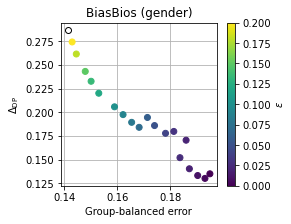

,group_balanced_err,dp_gap
no_postprocess,0.141422,0.286506
0.2,0.143032,0.274054
0.18,0.144604,0.261364
0.15,0.147970,0.243030
0.135,0.150169,0.232657
0.12,0.153057,0.220064
0.1,0.158976,0.205756
0.09,0.162190,0.197553
0.08,0.165423,0.189411
0.07,0.168240,0.184161


In [9]:
eps = [
    0.2, 0.18, 0.15, 0.135, 0.12, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03,
    0.025, 0.02, 0.018, 0.01, 0.004, 0.0
]
res = defaultdict(dict)
add_metrics_to_dict(res, "no_postprocess", test_labels,
                    np.argmax(test_probas, axis=1), test_groups, n_groups)
for e in eps:
  postprocessor = PostProcessorDP().fit(train_probas_post,
                                        train_groups_post,
                                        eps=e)
  test_preds = postprocessor.predict(test_probas, test_groups)
  add_metrics_to_dict(res, e, test_labels, test_preds, test_groups, n_groups)

plot_results(eps, res, "BiasBios (gender)")
display(pd.DataFrame(res))

In [10]:
# Get q_by_group under eps=0 from last post-processor in previous cell
q_by_group = postprocessor.q_by_group_

import importlib
import utils
importlib.reload(utils)

train_probas_post = utils.perturb(rng,
                                   train_probas_post,
                                   bw=bw,
                                   repeat=n_perturbations_train)
train_labels_post = np.repeat(train_labels_post, n_perturbations_train)
train_groups_post = np.repeat(train_groups_post, n_perturbations_train)

test_probas_perturbed = utils.perturb(rng,
                                       test_probas,
                                       bw=bw,
                                       repeat=n_perturbations_eval)
test_labels_repeated = np.repeat(test_labels, n_perturbations_eval)
test_groups_repeated = np.repeat(test_groups, n_perturbations_eval)

eps = [0.0]
res = defaultdict(dict)
for e in eps:
  postprocessor = PostProcessorDP().fit(train_probas_post,
                                        train_groups_post,
                                        eps=e,
                                        q_by_group=q_by_group)
  test_preds = postprocessor.predict(test_probas_perturbed,
                                     test_groups_repeated)
  add_metrics_to_dict(res, e, test_labels_repeated, test_preds,
                      test_groups_repeated, n_groups)

print("With smoothing:")
display(pd.DataFrame(res))

With smoothing:


,group_balanced_err,dp_gap
0.0,0.209051,0.118751
